<a href="https://colab.research.google.com/github/maxoboe/6419_recitations/blob/main/climate_video_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Application 1: Signal of Climate Change



*   Goal: assess degree that Middlesex county experienced visible climate change
* Refresh research question, math question
*   Meet the data
* Simulation exercise: 
  * Get to a stationary series 
  * Include exogenous regressors
  * Evaluate model fit with AIC/BIC 
* Is there a signal of climate change?
  * Find a model fit
  * Assess significance of climate signal

### Learning Goals
* Recognize nonlinear trend, seasonality components 
* Evaluate model fit from residuals
* Remove trend by differencing, fitting lines 
* Recognize seasonal component from ACF plots
* Remove seasonal components with sinusoidal/fixed effects approaches
* Use external regressors 
* Automate search for candidate models
* Use information criteria to select models 
* Evaluate statistical significance of trend


## General Approach
1. Pose research question (not covered in this recitation)
2. Find data (not covered in this recitation) 
3. Translate research question to math question (see last video) 
4. Select an appropriate model 
5. Conduct analysis
6. Interpret results 

## Climate Signal Research and Math Question

* Research Question: **Is there a significant temperature change in Middlesex County, given historical variability and natural cycles?**
* Math question: **Is the trend in average temperature statistically significant, after controlling for components that can be explained by seasonal components or ENSO index?**

### Main Dataset: Temperature Records

Temperature records are from Wolfram Schlenker, and are available [here](https://www.dropbox.com/sh/fe844ythm9xhz25/AABMmYzeY44zP_CwuNa1BOgoa?dl=0). This weather dataset was developed to study how crop yields respond to climate change, and includes a grid of values across the United States based on a network of weather stations. You can read more about that work [here](https://www.pnas.org/doi/10.1073/pnas.0906865106).

I'm looking at annual average temperatures in Middlesex county (where MIT is), but I encourage you to look at your own city or region of interest. The World Bank also has many great temperature datasets. 

In [1]:
import pandas as pd
import numpy as np

climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
climate_df.head()

,Unnamed: 0,fips,year,prec,tAvg,tMax,tMin
0,0,1001,1950.0,0.316240,18.562836,24.982644,12.143027
1,1,1003,1950.0,0.396390,19.632386,25.255855,14.008918
2,2,1005,1950.0,0.314359,18.764575,25.225654,12.303496
3,3,1007,1950.0,0.339745,17.712741,24.537339,10.888144
4,4,1009,1950.0,0.346355,16.051495,22.331040,9.771949


/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


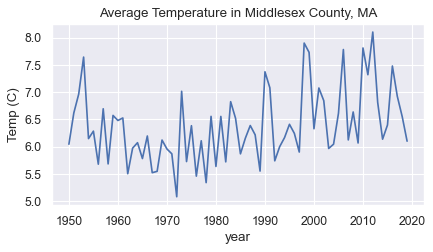

,Unnamed: 0,fips,year,prec,tAvg,tMax,tMin
1127,1127,23017,1950.0,0.261201,6.045459,12.384527,-0.293610
4164,4164,23017,1951.0,0.351008,6.617509,12.763306,0.471712
7201,7201,23017,1952.0,0.289846,6.964517,13.280014,0.649021
10238,10238,23017,1953.0,0.329602,7.642367,14.120450,1.164284
13275,13275,23017,1954.0,0.430148,6.147974,12.007143,0.288804


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
plt.figure(figsize=(6, 3), dpi=80)
subset = climate_df[climate_df.fips == 23017] # Only looking at Middlesex County
year = subset.year.values.reshape(-1,1)
temp = subset.tAvg.values.reshape(-1,1)
sns.lineplot(subset.year, subset.tAvg)
plt.title("Average Temperature in Middlesex County, MA")
plt.ylabel('Temp (C)')
plt.show()
subset.head()

### Analysis Goals from Math Question
* Math question: Is the trend in average temperature statistically significant, after controlling for components that can be explained by seasonal components or ENSO index?
* Analysis goals:
  * Test for seasonal components and ENSO 
  * Fit a linear trend and find its magnitude
  * Assess statistical significance

## Introducing Methods: Simulated Data
In this section, we focus on a simulated time series with a quadratic trend, a sinusoidal component, and an exogenous regressor.

To illustrate each approach, we fit each component in sequence. The order of this sequence is not important, as long as each term is independent. In practice, it's best to fit terms simultaneously using an estimation package. We show how to do this at the end of this section. 

We simulate with the following function:

$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$
where $z_t$ is an external regressor, $T_t$ is a quadratic trend component, and $S_t$ is a periodic component with period 5, and $\epsilon_t$ is random noise, normal and independent for different times $t$

In [4]:
# This code was used to generate the original dataset; 
import numpy as np
np.random.seed(1234)
x_vals = np.arange(0, 200)
z = 5 * np.random.beta(1,1,size=len(x_vals))
quad_trend = x_vals ** 2 * 0.004 + 0.2 * x_vals
seasonality = 2 * (x_vals % 5 == 0) + 3 * (x_vals % 5 == 1) + 1 * (x_vals % 5 == 2) - 1 * (x_vals % 5 == 4)
random_noise = np.random.normal(size=len(x_vals))
y_vals = quad_trend + seasonality + z + random_noise
x = x_vals.reshape(-1,1)
z = z.reshape(-1,1)
y = y_vals.reshape(-1,1)

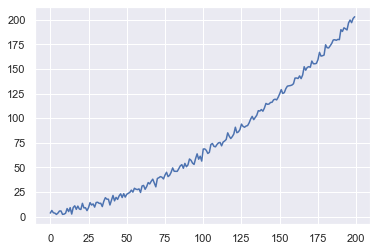

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
plt.plot(x, y)

### Remove trends

We'll show two ways to remove trends - first differencing, and fitting and removing a line. 
To fit and remove the line, I recommend using a regression package such as `sklearn.linear_model.LinearRegression` ( look [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for the user guide)


Removing via linear regression: 
Consider the model with only a linear time trend,
$$y_{t} = T_t + \varepsilon_t$$

One approach: find the line $y_t = t \beta$ that results in least squares fit. 

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(x, y)
print(clf.coef_) # Print the beta values found via regression 
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()

Always good practice to look at residuals after applying a transformation - do they look normal, or is there a remaining pattern? 

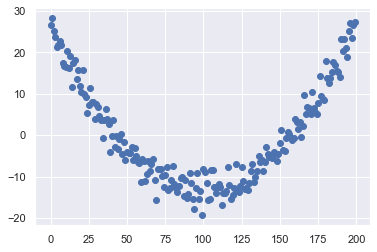

In [7]:
linear_residuals = y - y_hat
plt.plot(x, linear_residuals,'o')

Removing via first differences: 

Consider the model with only a linear time trend,
$$y_{t} = T_t + \varepsilon_t$$

Second approach: take first differences; model $$y_t - y_{t-1} = T_t - T_{t-1} + \varepsilon_{t} - \varepsilon_{t - 1}$$. If $T_t$ is linear, we should have $T_t - T_{t-1} = t\beta  - (t - 1)\beta  = \beta$.

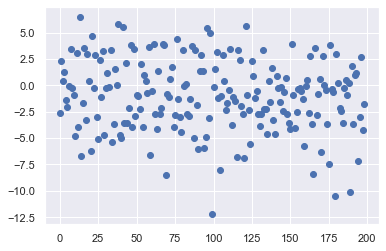

In [8]:
first_diff = y[:-1] - y[1:]
plt.plot(x[:-1],first_diff, 'o')

<AxesSubplot:>

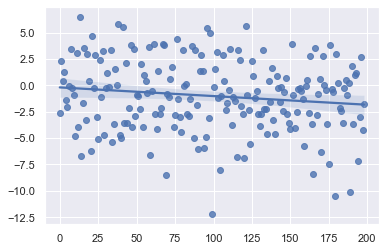

In [9]:
import seaborn as sns
sns.regplot(x=x[:-1], y=first_diff)

Removing quadratic trend via linear regression: 

$$y_{t} = T_t + \varepsilon_t; \qquad T_t = t \beta_1 + t^2 \beta_2$$

One approach: find coefficients $\hat{\beta}_1, \hat{\beta}_2$ such that $y_t = t \hat{\beta}_1 + t^2 \hat{\beta}_2 $  results in least squares fit. 

[[0.20453378 0.00399063]]


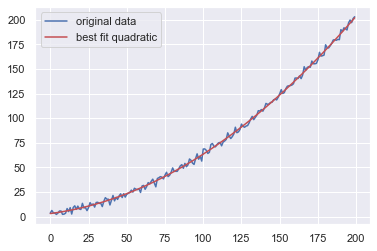

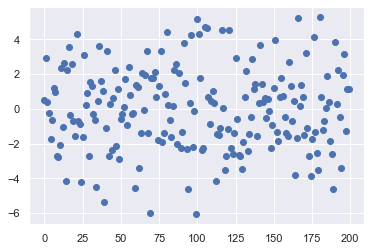

In [10]:
# Difference in this text block: we're including this squared term 
x_stacked = np.hstack((x, x**2))
clf.fit(x_stacked, y)
quadratic_y_hat = clf.predict(x_stacked)
print(clf.coef_) # Print the beta values found via regression 
plt.plot(x, y, label='original data')
plt.plot(x, quadratic_y_hat, 'r', label='best fit quadratic')
plt.legend()
plt.show()
nonlinear_residuals = y - quadratic_y_hat
plt.plot(x, nonlinear_residuals,'o');

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

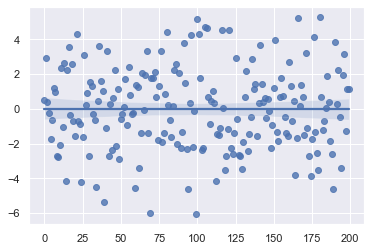

In [11]:
sns.regplot(x, nonlinear_residuals)

Removing quadratic trend via differencing: 

$$y_{t} = T_t + \varepsilon_t; \qquad T_t = t \beta_1 + t^2 \beta_2$$

Second approach: take two rounds of differences; $$\Delta y_t = y_t - y_{t-1} = T_t - T_{t-1} + \varepsilon_{t} - \varepsilon_{t - 1}$$. When we expand $T_t$, this becomes: $t^2 \beta_2 + t \beta_1 - (t^2 - 2t + 1) \beta_2 - (t - 1)\beta_1$. 

The squared terms cancel out, but we're left with a linear term: $2t \beta_2 - \beta_2 + \beta_1$. As we saw before, first differencing removes the linear component, so we just take another difference. 

You can do this successively to remove any polynomial component. 

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

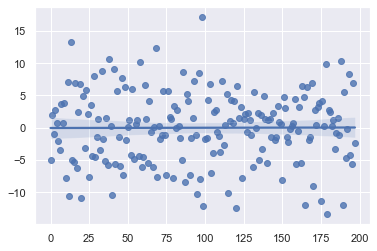

In [12]:
# Alternate approach: taking a second difference
first_diff = y[:-1] - y[1:]
second_diff = first_diff[:-1] - first_diff[1:]
sns.regplot(x[:-2],second_diff, 'o')

From our original model:

$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$

We've now found a way to estimate $T_t$; let's call that $\hat{T}_t$. Now, after removing that trend, we have: 

$$y_{t} - \hat{T}_t = z_t + S_t + \varepsilon_t$$

Next stop, dealing with $S_t$. 

### ACF/PACF Plots
These plots are a useful tool for a many applications, including for identifying the existence of seasonal components in a dataset. 

I recommend using the time series analysis package from `statsmodels`, available [here](https://www.statsmodels.org/dev/_modules/statsmodels/graphics/tsaplots.html)

In [ ]:
# Note: if you can't run this code with statsmodels, run this line. 
# You may need to restart the notebook. 
# !pip install statsmodels --upgrade

Reminder: 

ACF (Autocorrelation) = $\displaystyle \rho_X(h) = \hat{\gamma}(h) / \hat{\gamma}(0)$, where $\hat{\gamma}(h)$ is the autocovariance function at distance $X$. 

Error band comes from the error in estimating the autocovariance function; this is computed automatically by statsmodels. 

PACF (Partial Autocorrelation): performed iteratively, at each time step, remove the effect from all time steps in between $0$ and $h$. 

We use these for a few purposes - one is to look for existence of a periodic or seasonal component. 

Here, we run the ACF and PACF plots on the detrended series. We're looking for existence of a periodic component, which we see as a periodic component in the terms of both the ACF and PACF. It's easier to see in the ACF series.


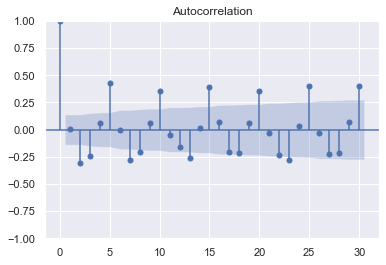

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


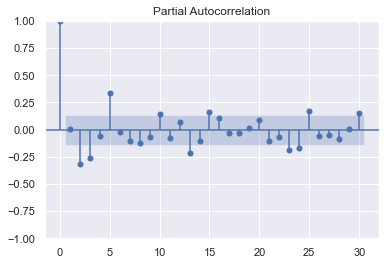

In [13]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(nonlinear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(nonlinear_residuals, lags=30)
plt.show()

### Removing Seasonal Component 
The first step is identifying the periodicity of the seasonal component, which we do by inspecting the time series and the ACF/PACF plots. 

After this stage, we present two methods to remove the seasonal component: by using a sinusoidal approximation to the seasonal component, and by fitting fixed-effects terms. 

Sinusoidal Approximation

Here, we use an optimization package to find the best sinusoidal approximation to this pattern. 

This assumes that the model has already been de-trended, and looks for the best fit model of the following form: 
$$ S_t = a + b \sin\left(\phi + \frac{t * 2 \pi }{period}\right)
$$
where $a$ is the mean of the sine function, $b$ is the amplitude, and $\phi$ is the phase shift. 
We assume that the period has already been determined, although it would be possible to use the optimizer to find this value as well. 

Note that here, we are estimating 3 variables (a, b, and $\phi$), so we are using 3 degrees of freedom. 

[ 1.92428900e+00 -2.93991758e-01  5.19207027e-08]


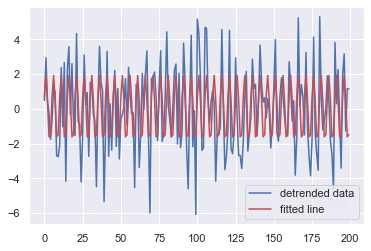

1.6194563301526679


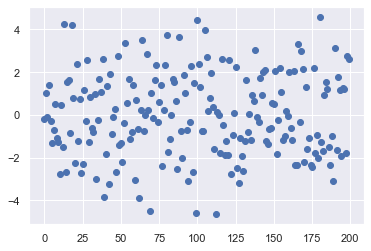

In [14]:
from scipy import optimize
period = 5
def sine_function(X, amp, phase_shift, mean):
  return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
params, _ = sine_curve_fit = optimize.curve_fit(
  f = sine_function,
  xdata = x.flatten(),
  ydata = nonlinear_residuals.flatten(),
  p0 = np.array([3, 1, 10]))
print(params)
amp, phase_shift, mean = params
sin_approx = sine_function(x, amp, phase_shift, mean)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, sin_approx, 'r', label='fitted line')
plt.legend()
plt.plot()
plt.show()
sin_residuals = nonlinear_residuals - sin_approx
plt.plot(x, sin_residuals,'o');
print(np.mean(np.abs(sin_residuals)))

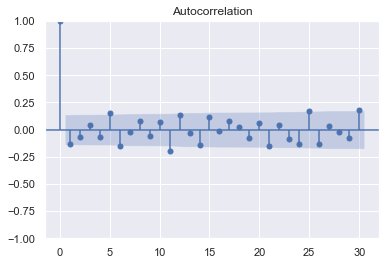

In [15]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(sin_residuals, lags=30)
plt.show()

Another approach: time-series fixed effects

Here, we remove the mean from each time element up to the time series. If the period is $5$, we fit an element for $\{0, 1, 2, 3, 4\}$, and then we find $S_t$ by looping voer those fixed elements. 

One way of writing this: 
$S_t = \sum_{i = 0} ^{period} \beta_i \{t \% period == i\} $.

We can estimate these values by taking the mean at each point, or by fitting a regression with a "fixed effect" term at each integer modulus. This is the approach I use. 

[[ 0.00000000e+00 -1.28956865e+13 -1.28956865e+13 -1.28956865e+13
  -1.28956865e+13 -1.28956865e+13]]


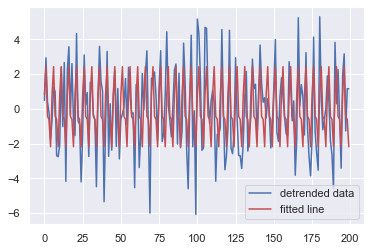

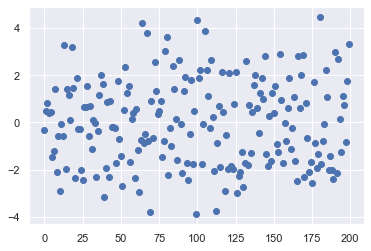

In [16]:
period = 5
x_with_fixed_effects = np.ones(x.shape)
for i in range(period):
  x_with_fixed_effects = np.hstack((x_with_fixed_effects, (x % period)==i))
clf.fit(x_with_fixed_effects, nonlinear_residuals)
print(clf.coef_)
fixed_effects_predicted = clf.predict(x_with_fixed_effects)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, fixed_effects_predicted, 'r', label='fitted line')
plt.legend();
plt.plot()
plt.show()
fixed_effects_residuals = nonlinear_residuals - fixed_effects_predicted
plt.plot(x, fixed_effects_residuals, 'o')

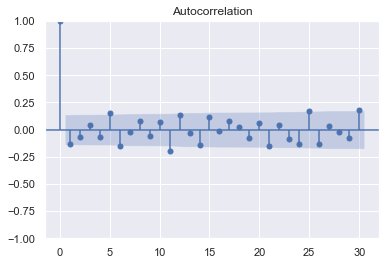

In [17]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(sin_residuals, lags=30)
plt.show()

To go back to our model: 

$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$

We now have estimates for $T_t$ and $S_t$; once we remove these, we have: 

$$y_{t} - \hat{T}_t - \hat{S}_t = z_t  + \varepsilon_t$$

Next step: how to deal with this external regressor, $z_t$. 

### Fitting external regressors
If you have a regressor you believe could be correlated with your series, you can also fit this component to the series and try to remove any of its associated noise. 

How do you find external regressors? This depends on your application, and isn't really a subject of this course. In many cases, there are sources of expert guidance (scientific or theoretical advice) about what might be relevant to the problem at hand. 

We show that the variable "Z" may be correlated with our residuals by plotting the residuals vs z. 
To test if a component is correlated, we use Spearman's rank correlation; see the python package [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html). There are many other tests for correlation in time series. 

Formula for the correlation: 

$$r_s =
 \rho_{R(X),R(Y)} =
 \frac{cov(R(X), R(Y))}{\sigma_{R(X)} \sigma_{R(Y)}}$$

where $R(X)$ is the rank of $X$, and $\rho$ is Pearson's correlation coefficient:
$$\rho(X, Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}$$

This coefficient lies between -1 and 1 and summarizes how closely correlated the ranks of two variables are; this tells you if any monotonic relationship exists that relates the two variables. A value close to 0 indicates that no monotonic relationship can transform $X$ to $Y$. 

SpearmanrResult(correlation=0.804566114152854, pvalue=1.0869662209907695e-46)

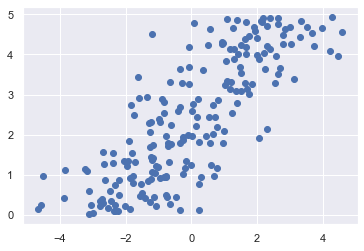

In [18]:
from scipy import stats
plt.scatter(sin_residuals, z)
stats.spearmanr(sin_residuals,z)

[[1.0136222]]


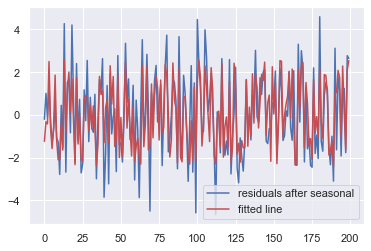

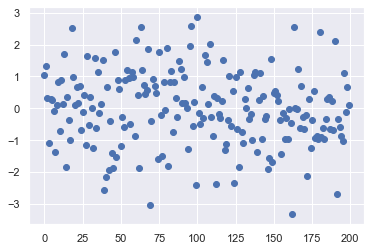

In [19]:
clf.fit(z, sin_residuals)
with_external_regressor = clf.predict(z)
print(clf.coef_) # Print the beta values found via regression 
plt.plot(x, sin_residuals, label='residuals after seasonal')
plt.plot(x, with_external_regressor, 'r', label='fitted line')
plt.legend()
plt.show()
external_residuals = sin_residuals - with_external_regressor
plt.plot(x, external_residuals,'o');

To go back to our model: 

$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$

We now have estimates for $T_t$, $S_t$, and $z_t$; once we remove these, we have: 

$$y_{t} - \hat{T}_t - \hat{S}_t - \hat{\beta} z_t = \varepsilon_t$$

Now, we have a stationary time series that is uncorrelated with our external regressor. 

### Information Criteria
To select which model to use, comparing mean squared error is a good starting place, but it's better to have some other metrics. 
Information criteria are one such metric, that tell you about the balance between gaining more accuracy from including more terms and potentially overfitting the model. 
Models are selected to minimize AIC/BIC. 

Idea: find a balance between model fit and complexity. 

AIC (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$ 

BIC (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$ 

where $k$ is the model complexity (degrees of freedom used up) and $n$ is the number of elements. 

A good practice is to select a model that minimizes both of these criteria; when they disagree, turn to another approach like out-of-sample validation. 

In [20]:
# Example here about how to find; what my assumption is behind this 
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

In [21]:
# plt.plot(x, detrended, label='detrended data')
for residual, label, DOF_used in zip([linear_residuals, nonlinear_residuals, sin_residuals, fixed_effects_residuals, external_residuals], 
                         ['linear', 'nonlinear', 'sinusoidal', 'fixed effects', 'with external regressor'], 
                         [1, 2, 5, 7, 6]):
  print('Mean squared error with {} method is: {}'.format(label, np.nanmean((residual)**2)))
  print('AIC with {} method is: {}'.format(label, evaluate_AIC(DOF_used, residual)))
  print('BIC with {} method is: {}'.format(label, evaluate_BIC(DOF_used, residual)))
  print('-'*20)

Mean squared error with linear method is: 147.18674877057714
AIC with linear method is: 1567.9158493425778
BIC with linear method is: 1571.2141667091257
--------------------
Mean squared error with nonlinear method is: 5.647710964231746
AIC with nonlinear method is: 917.8254780805321
BIC with nonlinear method is: 924.4221128136281
--------------------
Mean squared error with sinusoidal method is: 3.796266864123098
AIC with sinusoidal method is: 844.3790492176581
BIC with sinusoidal method is: 860.8706360503983
--------------------
Mean squared error with fixed effects method is: 3.29871337774575
AIC with fixed effects method is: 820.281914665013
BIC with fixed effects method is: 843.3701362308493
--------------------
Mean squared error with with external regressor method is: 1.3583468851661653
AIC with with external regressor method is: 640.8291002387482
BIC with with external regressor method is: 660.6190044380364
--------------------


### Interpretation: 

The information criteria, and mean squared error, both select for the model with external regressor, periodic component, and quadratic trend. Just like what we specified in the model! 

$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$

AIC, BIC, and mean squared error all agree that we should include our estimates of $z_t$, $T_t$, and $S_t$. Nice job, we converted this simulated dataset to white noise! 

### Note on Order of Operations
In practice, it's best to fit all components simultaneously. To determine which components to consider, it's good practice to test components sequentially and examine residuals. 

We show another order of operations. For this example, you are able to find the same trend component with a different order of operations, but different coefficients for other estimates. 
Then we'll show how to use a python package to fit each component simultaneously. 

[ 0.50935449  0.49387583 76.26285802]


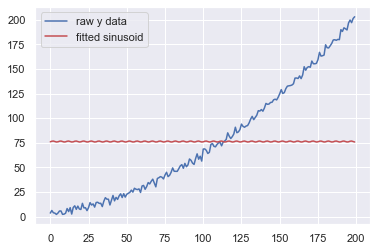

50.70958906373837


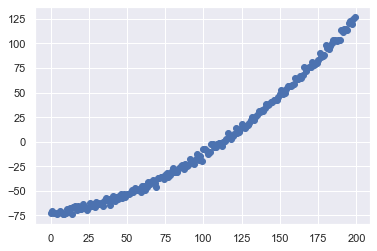

In [22]:
# Alternate order: seasonal, external, then quadratic trend 
from scipy import optimize
period = 5
def sine_function(X, amp, phase_shift, mean):
  return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
params, _ = sine_curve_fit = optimize.curve_fit(
  f = sine_function,
  xdata = x.flatten(),
  ydata = y.flatten(),
  p0 = np.array([3, 1, 10]))
print(params)
amp, phase_shift, mean = params
sin_approx = sine_function(x, amp, phase_shift, mean)
plt.plot(x, y, label='raw y data')
plt.plot(x, sin_approx, 'r', label='fitted sinusoid')
plt.legend()
plt.plot()
plt.show()
sin_residuals = y - sin_approx
plt.plot(x, sin_residuals,'o');
print(np.mean(np.abs(sin_residuals)))

SpearmanrResult(correlation=0.13793744843621092, pvalue=0.05143604206062729)

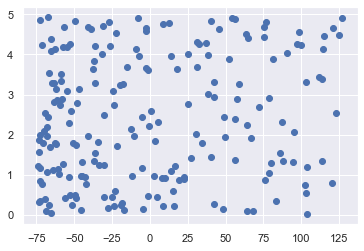

In [23]:
from scipy import stats
plt.scatter(sin_residuals, z)
stats.spearmanr(sin_residuals,z)

[[5.60250725]]


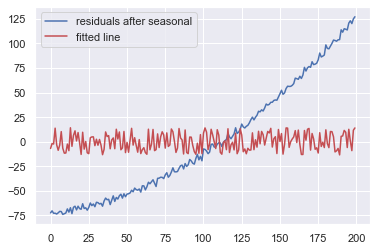

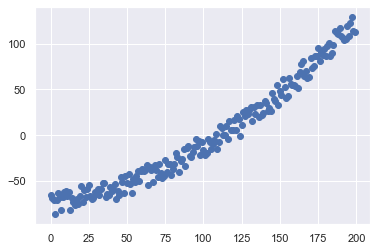

In [24]:
clf.fit(z, sin_residuals)
with_external_regressor = clf.predict(z)
print(clf.coef_) # Print the beta values found via regression 
plt.plot(x, sin_residuals, label='residuals after seasonal')
plt.plot(x, with_external_regressor, 'r', label='fitted line')
plt.legend()
plt.show()
external_residuals = sin_residuals - with_external_regressor
plt.plot(x, external_residuals,'o');

[[0.21358343 0.00386009]]


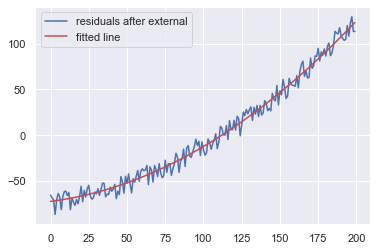

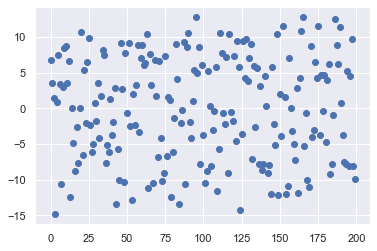

In [25]:
x_stacked = np.hstack([x, x**2])
clf.fit(x_stacked, external_residuals)
print(clf.coef_)
with_trend = clf.predict(x_stacked)
plt.plot(x, external_residuals, label='residuals after external')
plt.plot(x, with_trend, 'r', label='fitted line')
plt.legend()
plt.show()
final_residuals = external_residuals - with_trend
plt.plot(x, final_residuals,'o');

### Simultaneously Fitting Components
It's good practice to fit components simultaneously, as the parameter estimate can vary with order. 
If you need to do them in order, go through the order from class: first remove a trend, then look for periodic components. 

You can do this with ordinary least squares or with a time series package, such as [this one](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html). Such time series packages are largely designed to consider ARMA models, and their behavior may vary for a case like this. Be sure to inspect that models are converging to appropriate results. 


$$y_{t} = z_t + T_t + S_t + \varepsilon_t$$

When we say "fit simultaneously", we mean jointly search for parameters that define all of these relationships. 

[[ 0.20666871  0.0039676   0.99114436  0.98051602  2.12999487 -0.09394378
  -0.89236406 -2.12420304]]


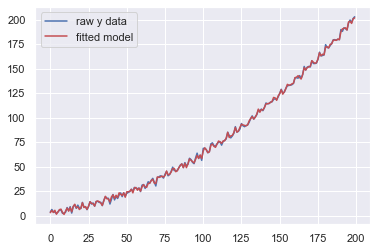

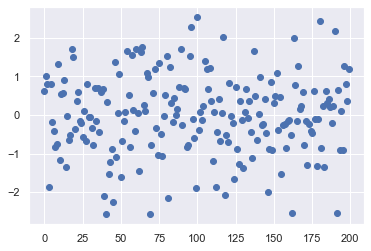

In [26]:
# One way to simulatenously fit these components is with OLS
x_stacked = np.hstack([x, x**2, z])
period = 5
for i in range(period):
  x_stacked = np.hstack((x_stacked, (x % period)==i))
clf.fit(x_stacked, y)
print(clf.coef_)
simulatenous_predictions = clf.predict(x_stacked)
plt.plot(x, y, label='raw y data')
plt.plot(x, simulatenous_predictions, 'r', label='fitted model')
plt.legend()
plt.plot()
plt.show()
residuals = y - simulatenous_predictions
plt.plot(x, residuals,'o');

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  200
Model:                   AutoReg-X(0)   Log Likelihood                -289.120
Method:               Conditional MLE   S.D. of innovations              1.027
Date:                Fri, 13 May 2022   AIC                            596.241
Time:                        09:46:56   BIC                            625.925
Sample:                             0   HQIC                           608.254
                                  200                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
trend             0.1987      0.005     39.307      0.000       0.189       0.209
trend_squared     0.0040   2.44e-05    162.705      0.000       0.004       0.004
s(1,5)            1.5908      0.281     

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:227: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  warnings.warn(


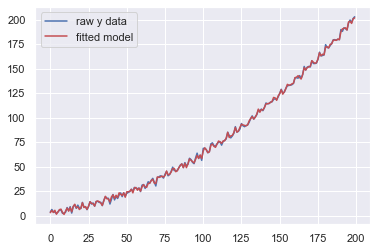

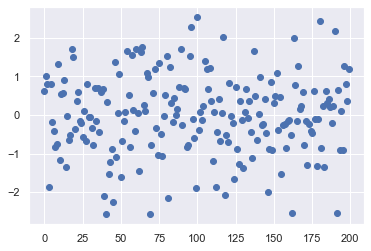

In [27]:
# With a Python package
exog = z
period = 5
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import DeterministicProcess
det_comp = DeterministicProcess(x.flatten(), period=period, order=2, seasonal=True)
model = AutoReg(y, exog=exog, deterministic=det_comp, lags=None).fit()
print(model.summary())
model_predictions = model.predict(exog=exog)
plt.plot(x, y, label='raw y data')
plt.plot(x, model_predictions, 'r', label='fitted model')
plt.legend()
plt.plot()
plt.show()
residuals = y - model_predictions.reshape(-1,1)
plt.plot(x, residuals,'o');

## Reviewing Model Selection: 
1. Do we need to scale the data? 
2. Fit (non)linear trend to the data?
3. Fit seasonal components?
4. Fit external regressors? 
5. Fit AR/MA model? 

## Returning to our Problem
* Math question: Is the trend in average temperature statistically significant, after controlling for components that can be explained by seasonal components or ENSO index?
* Analysis goals:
  * Test for seasonal components and ENSO 
  * Fit a linear trend and find its magnitude
  * Assess statistical significance

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


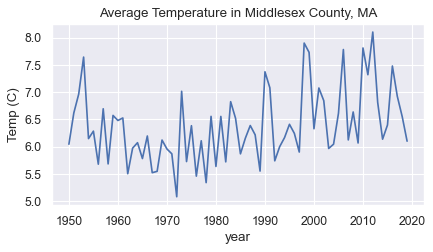

,Unnamed: 0,fips,year,prec,tAvg,tMax,tMin
1127,1127,23017,1950.0,0.261201,6.045459,12.384527,-0.293610
4164,4164,23017,1951.0,0.351008,6.617509,12.763306,0.471712
7201,7201,23017,1952.0,0.289846,6.964517,13.280014,0.649021
10238,10238,23017,1953.0,0.329602,7.642367,14.120450,1.164284
13275,13275,23017,1954.0,0.430148,6.147974,12.007143,0.288804


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
plt.figure(figsize=(6, 3), dpi=80)
subset = climate_df[climate_df.fips == 23017] # Only looking at Middlesex County
year = subset.year.values.reshape(-1,1)
temp = subset.tAvg.values.reshape(-1,1)
sns.lineplot(subset.year, subset.tAvg)
plt.title("Average Temperature in Middlesex County, MA")
plt.ylabel('Temp (C)')
plt.show()
subset.head()

### Do we need to adjust scale? 
Can take log transformation, or other transformation, if data does not appear to have constant scale throughout. 

Does not appear to be relevant for this dataset. 

### Can we fit a linear trend? 

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


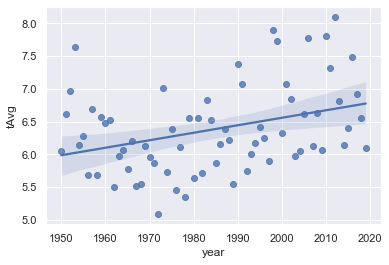

[[0.01144365]]


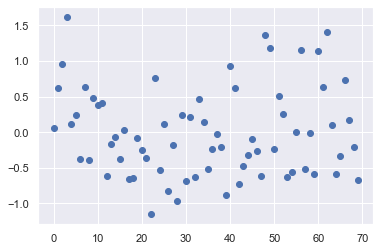

In [29]:
sns.regplot(subset.year, subset.tAvg)
plt.show()
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, temp)
print(clf.coef_)
linear_residuals = temp - clf.predict(year)
plt.plot(linear_residuals, 'o')

### Fitting Seasonal Component 
First, look if there is evidence of a seasonal component from the ACF/PACF plots.

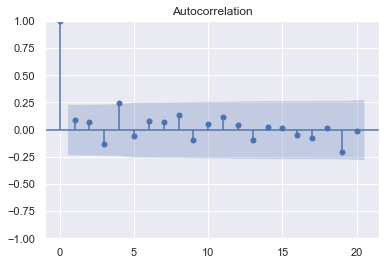

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


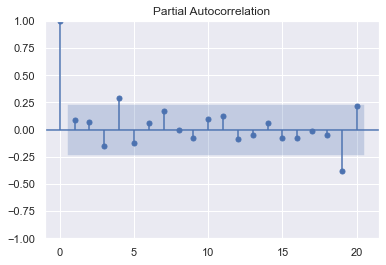

In [30]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(linear_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=20)
plt.show()


### Not strong evidence of periodic component 
For thoroughness, we'll search through for a component that minimizes MSE. 

But these ACF/PACF plots tell me that we may not need to include a periodic component for this time series. 

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


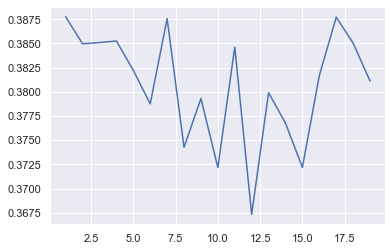

minimizing period is: 12


In [31]:
from scipy import optimize
period_range = np.arange(1, 20)
mse_list = []

def find_sine_approximation(period, x_data=year, y_data=temp):
  """
  Finds a best-fitting sinusoidal approximation, for the given period. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, linear_residuals)
  mse = np.nanmean((linear_residuals - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)
sin_residuals = linear_residuals - find_sine_approximation(period_guess, year, linear_residuals)

### External Regressor: Consider El Nino index

El Nino index is from [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php); we use ONI, which is a measure of how anomalously warm or cool the central-to-eastern equatorial Pacific Ocean is compared to "normal".

I've aggregated this data to yearly values to standardize the comparison; this index is only available from 1950-2020 so we focus on that range while incorporating this regressor. 

Climate science informs us that this regressor is often correlated with global temperature patterns, so we test for a correlation in this dataset. 

Text(0, 0.5, 'ONI')

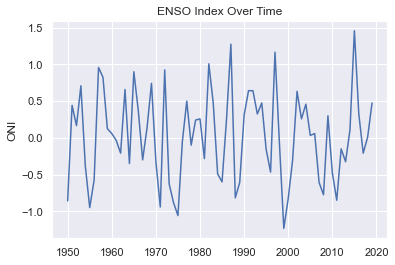

In [32]:
import pandas as pd
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df[enso_df.year.isin(climate_df.year)]['ONI_index'].values.reshape(-1,1)
plt.plot(year, ONI)
plt.title("ENSO Index Over Time")
plt.ylabel("ONI")

SpearmanrResult(correlation=-0.12904975717128836, pvalue=0.28699964373818654)

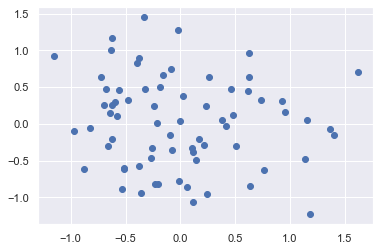

In [33]:
from scipy import stats
plt.scatter(linear_residuals, ONI)
stats.spearmanr(linear_residuals,ONI)

From this correlation, we would conclude that we shouldn't include ENSO in our model.

If we wanted to more rigorously test for a relationship, we could also consider the correlation between lagged values of the ENSO index and our temperature variable. We'll leave this extension as an exercise to the interested learner. 

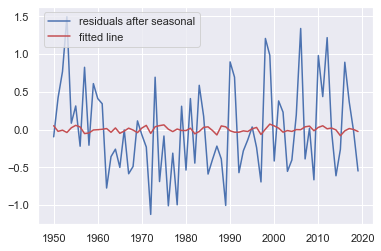

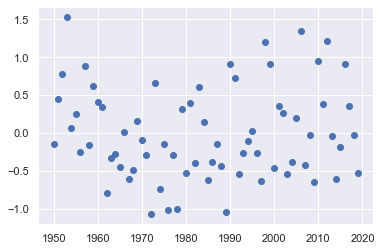

In [34]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(ONI, sin_residuals)
with_external_regressor = clf.predict(ONI)
plt.plot(year, sin_residuals, label='residuals after seasonal')
plt.plot(year, with_external_regressor, 'r', label='fitted line')
plt.legend()
plt.show()
external_residuals = sin_residuals - with_external_regressor
plt.plot(year, external_residuals,'o');

### Do we need to find ARMA components?
Here, we don't see evidence of ARMA components. You can see this from the ACF/PACF plots - neither displays the decaying pattern that would indicate presence of a AR/MA component. 

We'll talk more about how to find ARMA fits in the next module. 

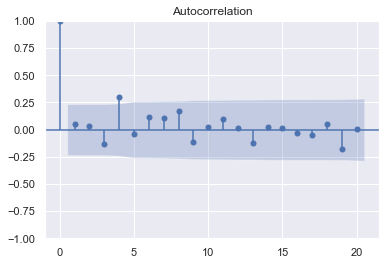

/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


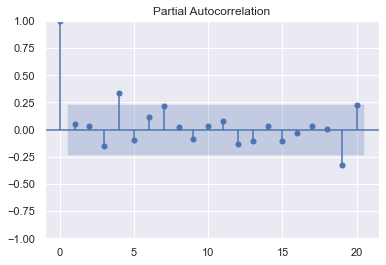

In [35]:
sm.graphics.tsa.plot_acf(external_residuals, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(external_residuals, lags=20)
plt.show()

### Model Selection
Here, we test each combination of models simultaneously. We select a model based on AIC and BIC. 

We automate a search over a range of potential values, and select the model with minimal AIC and BIC. 

In [49]:
exog = z
period = 5
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import DeterministicProcess

min_AIC=np.inf
min_BIC = np.inf
AIC_choice = None
BIC_choice = None

for period in [None] + list(np.arange(2, 13)):
  for order in [0, 1]:
    for exog, exog_label in zip([ONI, None], ['ONI',None]):
      det_comp = DeterministicProcess(year.flatten(), period=period, constant=True,
                                      order=order, seasonal=period is not None)
      model = AutoReg(temp, exog=exog, deterministic=det_comp, lags=None, 
                      trend='n',seasonal=False).fit()
      # print("Model has period {}, order {}, exog {}".format(period, order, exog_label))
      # print("AIC", model.aic, "BIC", model.bic )
      # print("-"*20)
      if model.aic < min_AIC:
        AIC_choice = (period, order, exog_label)
        min_AIC = model.aic
      if model.bic < min_BIC:
        BIC_choice = (period, order, exog_label)
        min_BIC = model.bic 
print("AIC chooses a model with period {}, order {}, exog {}".format(*AIC_choice))
print("BIC chooses a model with period {}, order {}, exog {}".format(*BIC_choice))



AIC chooses a model with period None, order 1, exog None
BIC chooses a model with period None, order 1, exog None


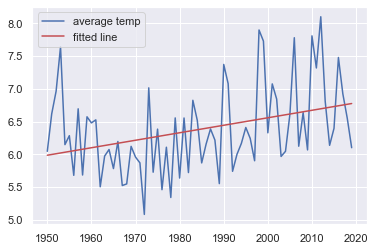

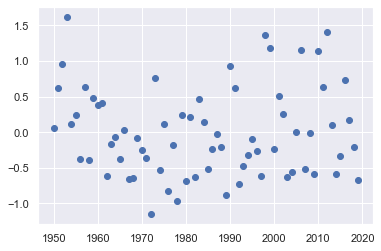

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   70
Model:                     AutoReg(0)   Log Likelihood                 -66.167
Method:               Conditional MLE   S.D. of innovations              0.623
Date:                Fri, 13 May 2022   AIC                            138.335
Time:                        10:02:30   BIC                            145.080
Sample:                             0   HQIC                           141.014
                                   70                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9746      0.150     39.708      0.000       5.680       6.270
trend          0.0114      0.004      3.107      0.002       0.004       0.019


In [51]:
period, order, exog = AIC_choice
det_comp = DeterministicProcess(year.flatten(), period=period, order=order, constant=True, seasonal =period is not None)
model = AutoReg(temp, exog=exog, deterministic=det_comp, lags=None, trend='n',seasonal=False).fit()
model_predictions = model.predict()
plt.plot(year, temp, label='average temp')
plt.plot(year, model_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
residuals = temp - model_predictions.reshape(-1,1)
plt.plot(year, residuals,'o');
plt.show()
print(model.summary())

## Interpretation: 
* Our model fitting procedure selects a trend component 
* AIC and BIC agree on model selection
* From output of the model, trend has coefficient of 0.0114 with a p-value lower than 0.01. 
* Statistically significant climate change 

## Summary: Analysis Steps for Model Selection
1. Do we need to scale the data? 
2. Fit (non)linear trend to the data?
3. Fit seasonal components?
4. Fit external regressors? 
5. Fit AR/MA model? 

We showed how to go through steps 2-4, on a simulated dataset and on a real-world example of climate data. 

We accomplished these learning goals:
* Recognize nonlinear trend, seasonality components 
* Evaluate model fit from residuals
* Remove trend by differencing, fitting lines 
* Recognize seasonal component from ACF plots
* Remove seasonal components with sinusoidal/fixed effects approaches
* Use external regressors 
* Automate search for candidate models
* Use information criteria to select models 
* Evaluate statistical significance of trend